In [190]:
import requests, json
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
from datetime import datetime
NWSAPIURLSTART = 'https://api.weather.gov'

headers = {"User-Agent": "Forecast Accuracy Testing, ben.g.hunt@gmail.com"}


def get_location_url_from_coords(lat,lon):
    return NWSAPIURLSTART + '/points/' +str(lat) + ',' + str(lon)

def get_gridX_gridY_office_from_location_url(location_url):
    r = requests.get(location_url)
    if (r.status_code == 200):
        j = json.loads(r.text)
        d = {}
        d['gridX'] = j['properties']['gridX']
        d['gridY'] = j['properties']['gridY']
        d['office'] = j['properties']['cwa']
        return d
    else:
        print(r)

        
def get_grid_endpoint_from_dict(d):
    return NWSAPIURLSTART + '/gridpoints/' + str(d['office']) + '/' + str(d['gridX']) + ',' + str(d['gridY'])



In [171]:
r = requests.get('https://gist.githubusercontent.com/Miserlou/c5cd8364bf9b2420bb29/raw/2bf258763cdddd704f8ffd3ea9a3e81d25e2c6f6/cities.json')
r

<Response [200]>

In [172]:
j = json.loads(r.text)

In [173]:
print(j[0].keys())
print(j[0]['latitude'])
print(j[0]['longitude'])
print(j[0]['city'])
print(j[0]['state'])

dict_keys(['city', 'growth_from_2000_to_2013', 'latitude', 'longitude', 'population', 'rank', 'state'])
40.7127837
-74.0059413
New York
New York


In [174]:
url = get_location_url_from_coords(j[0]['latitude'], j[0]['longitude'])
print(url)

https://api.weather.gov/points/40.7127837,-74.0059413


In [175]:
lr = requests.get(url)

In [176]:
lj = json.loads(lr.text)
print(lj['properties']['gridX'])
print(lj['properties']['gridY'])
print(lj['properties']['cwa'])

32
34
OKX


In [177]:
gridpointsurl = get_grid_endpoint_from_dict(get_gridX_gridY_office_from_location_url(url))
print(gridpointsurl)

https://api.weather.gov/gridpoints/OKX/32,34


In [178]:
gridr = requests.get(gridpointsurl)
gridr

<Response [200]>

In [179]:
gridjson = json.loads(gridr.text)
gridjson.keys()

dict_keys(['@context', 'id', 'type', 'geometry', 'properties'])

In [180]:
gridjson['geometry']['coordinates'][0]
time_nws = gridjson['properties']['validTimes']
t1 = datetime.strptime(time_nws.split('+')[0], '%Y-%m-%dT%H:%M:%S').timestamp()
print(t1)
two_days_old = t1-(2*24*60*60)
print(two_days_old)

1657648800.0
1657476000.0


In [181]:

polygon_points = []
for coord in gridjson['geometry']['coordinates'][0]:
    polygon_points.append(Point(coord[1],coord[0]))
box = Polygon(polygon_points)
for point in polygon_points:
    print(point.x)
    print(point.y)
box.contains(Point(40.7127837,-74.0059413))
print(datetime.now().timestamp())

40.7270524
-74.0250952
40.7053617
-74.0295579
40.7019775
-74.0009483
40.723667899999995
-73.9964798
40.7270524
-74.0250952
1657658491.139978


In [202]:
missed_gridpoints = 0
successful_gridpoints = 0
miles_off = []
off_grid_points = []


bad_times = []
now_time = datetime.now().timestamp()
two_days_old = (now_time - (2*24*60*60))
gridpoints_too_old = 0
gridpoints_good_time = 0

def define_polygon_from_gridpoints_json(grid_json):
    polygon_points = []
    for coord in grid_json['geometry']['coordinates'][0]:
        polygon_points.append(Point(coord[1],coord[0]))
    return(Polygon(polygon_points))
    


for city in j[:300]:
    print(city['city'])
    city_lat = city['latitude']
    city_lon = city['longitude']
    url = get_location_url_from_coords(city_lat, city_lon)
    print(url)
    gridpointsurl = get_grid_endpoint_from_dict(get_gridX_gridY_office_from_location_url(url))
    print(gridpointsurl)
    gridpoint_request = requests.get(gridpointsurl)
    print(gridpoint_request)
    if gridpoint_request.status_code ==200:
        print('good request')
        grid_json = json.loads(gridpoint_request.text)
        box = define_polygon_from_gridpoints_json(grid_json)
        city_point = Point(city_lat,city_lon)
        print(str(city_point))
        grid_correct = box.contains(city_point)
        if grid_correct:
            print('good grid')
            successful_gridpoints += 1
        if not grid_correct:
            print('bad grid')
            off_grid_points.append(city_point)
            missed_gridpoints += 1
            dist_miles = 68*box.exterior.distance(city_point)
            print(str(city_lat) + ',' + str(city_lon) + ' is not in ' + str(grid_json['geometry']['coordinates'][0]))
            print("distance off: rough miles (vector dist * 68 mi): " + str(dist_miles))
            miles_off.append(dist_miles)
        forecast_time = grid_json['properties']['validTimes']
        forecast_timestamp = datetime.strptime(time_nws.split('+')[0], '%Y-%m-%dT%H:%M:%S').timestamp()
        if forecast_timestamp < two_days_old:
            print("more than two days old")
            print(forecast_time)
            bad_times.append(forecast_time)
            gridpoints_too_old += 1
        if forecast_timestamp > two_days_old:
            gridpoints_good_time += 1
    

New York
https://api.weather.gov/points/40.7127837,-74.0059413
https://api.weather.gov/gridpoints/OKX/32,34
<Response [200]>
good request
POINT (40.7127837 -74.0059413)
good grid
Los Angeles
https://api.weather.gov/points/34.0522342,-118.2436849
https://api.weather.gov/gridpoints/LOX/154,44
<Response [200]>
good request
POINT (34.0522342 -118.2436849)
good grid
Chicago
https://api.weather.gov/points/41.8781136,-87.6297982
https://api.weather.gov/gridpoints/LOT/75,72
<Response [200]>
good request
POINT (41.8781136 -87.6297982)
good grid
Houston
https://api.weather.gov/points/29.7604267,-95.3698028
https://api.weather.gov/gridpoints/HGX/63,94
<Response [200]>
good request
POINT (29.7604267 -95.3698028)
bad grid
29.7604267,-95.3698028 is not in [[-95.3543421, 29.8047451], [-95.3542736, 29.781985000000002], [-95.3280432, 29.782042200000003], [-95.32810669999999, 29.804802400000003], [-95.3543421, 29.8047451]]
distance off: rough miles (vector dist * 68 mi): 1.8066978744315942
Philadelphia


https://api.weather.gov/gridpoints/EAX/43,50
<Response [200]>
good request
POINT (39.0997265 -94.5785667)
good grid
Mesa
https://api.weather.gov/points/33.4151843,-111.8314724
https://api.weather.gov/gridpoints/PSR/167,54
<Response [200]>
good request
POINT (33.4151843 -111.8314724)
good grid
Virginia Beach
https://api.weather.gov/points/36.8529263,-75.97798499999999
https://api.weather.gov/gridpoints/AKQ/100,52
<Response [200]>
good request
POINT (36.8529263 -75.97798499999999)
good grid
Atlanta
https://api.weather.gov/points/33.7489954,-84.3879824
https://api.weather.gov/gridpoints/FFC/50,86
<Response [200]>
good request
POINT (33.7489954 -84.3879824)
good grid
Colorado Springs
https://api.weather.gov/points/38.8338816,-104.8213634
https://api.weather.gov/gridpoints/PUB/89,90
<Response [200]>
good request
POINT (38.8338816 -104.8213634)
good grid
Omaha
https://api.weather.gov/points/41.2523634,-95.99798829999999
https://api.weather.gov/gridpoints/OAX/80,59
<Response [200]>
good reque

<Response [200]>
good request
POINT (27.773056 -82.64)
good grid
Chandler
https://api.weather.gov/points/33.3061605,-111.8412502
https://api.weather.gov/gridpoints/PSR/166,49
<Response [200]>
good request
POINT (33.3061605 -111.8412502)
good grid
Laredo
https://api.weather.gov/points/27.5305671,-99.48032409999999
https://api.weather.gov/gridpoints/CRP/30,24
<Response [200]>
good request
POINT (27.5305671 -99.48032409999999)
good grid
Norfolk
https://api.weather.gov/points/36.8507689,-76.28587259999999
https://api.weather.gov/gridpoints/AKQ/89,51
<Response [200]>
good request
POINT (36.8507689 -76.28587259999999)
good grid
Durham
https://api.weather.gov/points/35.9940329,-78.898619
https://api.weather.gov/gridpoints/RAH/63,65
<Response [200]>
good request
POINT (35.9940329 -78.898619)
good grid
Madison
https://api.weather.gov/points/43.0730517,-89.4012302
https://api.weather.gov/gridpoints/MKX/37,63
<Response [200]>
good request
POINT (43.0730517 -89.4012302)
good grid
Lubbock
https://a

<Response [200]>
good request
POINT (30.6953657 -88.0398912)
good grid
Grand Rapids
https://api.weather.gov/points/42.9633599,-85.6680863
https://api.weather.gov/gridpoints/GRR/40,46
<Response [200]>
good request
POINT (42.9633599 -85.6680863)
good grid
Salt Lake City
https://api.weather.gov/points/40.7607793,-111.8910474
https://api.weather.gov/gridpoints/SLC/99,174
<Response [200]>
good request
POINT (40.7607793 -111.8910474)
good grid
Tallahassee
https://api.weather.gov/points/30.4382559,-84.28073289999999
https://api.weather.gov/gridpoints/TAE/83,85
<Response [200]>
good request
POINT (30.4382559 -84.28073289999999)
good grid
Huntsville
https://api.weather.gov/points/34.7303688,-86.5861037
https://api.weather.gov/gridpoints/HUN/62,42
<Response [200]>
good request
POINT (34.7303688 -86.5861037)
good grid
Grand Prairie
https://api.weather.gov/points/32.7459645,-96.99778459999999
https://api.weather.gov/gridpoints/FWD/81,102
<Response [500]>
Knoxville
https://api.weather.gov/points/35

https://api.weather.gov/gridpoints/BOX/22,56
<Response [500]>
Pasadena
https://api.weather.gov/points/29.6910625,-95.2091006
https://api.weather.gov/gridpoints/HGX/69,90
<Response [200]>
good request
POINT (29.6910625 -95.2091006)
bad grid
29.6910625,-95.2091006 is not in [[-95.1968158, 29.7139814], [-95.1967777, 29.6912209], [-95.1705831, 29.691251700000002], [-95.1706161, 29.714012300000004], [-95.1968158, 29.7139814]]
distance off: rough miles (vector dist * 68 mi): 0.838026424273951
Fort Collins
https://api.weather.gov/points/40.5852602,-105.084423
https://api.weather.gov/gridpoints/BOU/62,99
<Response [200]>
good request
POINT (40.5852602 -105.084423)
good grid
Hayward
https://api.weather.gov/points/37.6688205,-122.0807964
https://api.weather.gov/gridpoints/MTR/96,98
<Response [200]>
good request
POINT (37.6688205 -122.0807964)
bad grid
37.6688205,-122.0807964 is not in [[-122.0617065, 37.703709], [-122.0561278, 37.6818857], [-122.0286114, 37.6862879], [-122.0341847, 37.7081117], 

https://api.weather.gov/gridpoints/LOX/134,53
<Response [500]>
Cedar Rapids
https://api.weather.gov/points/41.9778795,-91.6656232
https://api.weather.gov/gridpoints/DVN/29,85
<Response [500]>
Charleston
https://api.weather.gov/points/32.7764749,-79.93105120000001
https://api.weather.gov/gridpoints/CHS/86,76
<Response [200]>
good request
POINT (32.7764749 -79.93105120000001)
good grid
Visalia
https://api.weather.gov/points/36.3302284,-119.2920585
https://api.weather.gov/gridpoints/HNX/66,78
<Response [200]>
good request
POINT (36.3302284 -119.2920585)
bad grid
36.3302284,-119.2920585 is not in [[-119.2896487, 36.3551639], [-119.2846978, 36.333142], [-119.2572894, 36.337137500000004], [-119.262235, 36.3591599], [-119.2896487, 36.3551639]]
distance off: rough miles (vector dist * 68 mi): 0.5383133982507494
Topeka
https://api.weather.gov/points/39.0558235,-95.68901849999999
https://api.weather.gov/gridpoints/TOP/80,48
<Response [200]>
good request
POINT (39.0558235 -95.68901849999999)
good

<Response [200]>
good request
POINT (33.6411316 -117.9186689)
good grid
Wilmington
https://api.weather.gov/points/34.2257255,-77.9447102
https://api.weather.gov/gridpoints/ILM/88,67
<Response [200]>
good request
POINT (34.2257255 -77.9447102)
good grid
Arvada
https://api.weather.gov/points/39.8027644,-105.0874842
https://api.weather.gov/gridpoints/BOU/59,64
<Response [200]>
good request
POINT (39.8027644 -105.0874842)
good grid
Inglewood
https://api.weather.gov/points/33.9616801,-118.3531311
https://api.weather.gov/gridpoints/LOX/149,41
<Response [200]>
good request
POINT (33.9616801 -118.3531311)
good grid
Miami Gardens
https://api.weather.gov/points/25.9420377,-80.2456045
https://api.weather.gov/gridpoints/MFL/106,57
<Response [200]>
good request
POINT (25.9420377 -80.2456045)
good grid
Carlsbad
https://api.weather.gov/points/33.1580933,-117.3505939
https://api.weather.gov/gridpoints/SGX/52,33
<Response [200]>
good request
POINT (33.1580933 -117.3505939)
good grid
Westminster
https:/

https://api.weather.gov/gridpoints/BOU/53,74
<Response [200]>
good request
POINT (40.0149856 -105.2705456)
good grid
West Palm Beach
https://api.weather.gov/points/26.7153424,-80.0533746
https://api.weather.gov/gridpoints/MFL/110,91
<Response [200]>
good request
POINT (26.7153424 -80.0533746)
good grid
Santa Maria
https://api.weather.gov/points/34.9530337,-120.4357191
https://api.weather.gov/gridpoints/LOX/82,98
<Response [200]>
good request
POINT (34.9530337 -120.4357191)
good grid
El Cajon
https://api.weather.gov/points/32.7947731,-116.9625269
https://api.weather.gov/gridpoints/SGX/64,15
<Response [500]>
Davenport
https://api.weather.gov/points/41.5236437,-90.5776367
https://api.weather.gov/gridpoints/DVN/67,65
<Response [500]>
Rialto
https://api.weather.gov/points/34.1064001,-117.3703235
https://api.weather.gov/gridpoints/SGX/58,75
<Response [200]>
good request
POINT (34.1064001 -117.3703235)
good grid
Las Cruces
https://api.weather.gov/points/32.3199396,-106.7636538
https://api.wea

In [203]:
print('lat lon not in grid:' + str(missed_gridpoints))
print('lat lon successful:' + str(successful_gridpoints))
print("error rate %: " +str(missed_gridpoints/ (successful_gridpoints+missed_gridpoints)))
import statistics
print('average distance to grid' + str(statistics.mean(miles_off)))
print(max(miles_off))
print(min(miles_off))
print('# of forecasts > 2 days old:' + str(gridpoints_too_old))

lat lon not in grid:40
lat lon successful:213
error rate %: 0.15810276679841898
average distance to grid1.2833106824752127
2.2121152357982545
0.00039482666254160755
# of forecasts > 2 days old:0


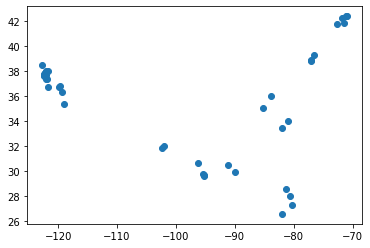

In [204]:
xs =[point.x for point in off_grid_points]
ys =[point.y for point in off_grid_points]
plt.scatter(ys,xs)

In [209]:
for bad_city_point in off_grid_points:
    city_lat = bad_city_point.x
    city_lon = bad_city_point.y
    print('lat, lon: '+ str(city_lat) +','+ str(city_lon))
    url = get_location_url_from_coords(city_lat, city_lon)
    print(url)
    d = get_gridX_gridY_office_from_location_url(url)
    print('desired and incorrect grid' + str(d['gridX']) + '' + str(d['gridY']))
    print('lets try (x, y) + 1')
    dy = d
    dy['gridX'] = d['gridX'] + 1
    dy['gridY'] = d['gridY'] + 1
    gridpointsurl = get_grid_endpoint_from_dict(dy)
    print(gridpointsurl)
    gridpoint_request = requests.get(gridpointsurl)
    if gridpoint_request.status_code ==200:
        grid_json = json.loads(gridpoint_request.text)
        box = define_polygon_from_gridpoints_json(grid_json)
        grid_correct = box.contains(bad_city_point)
        if grid_correct:
            print('(x, y)+1 successful!')
        if not grid_correct:
            print('(x, y)+1 didnt work, trying (x, y)-1')
            dy['gridX'] = d['gridX'] - 2
            dy['gridY'] = d['gridY']-2
            gridpointsurl = get_grid_endpoint_from_dict(dy)
            print(gridpointsurl)
            gridpoint_request = requests.get(gridpointsurl)
            if gridpoint_request.status_code ==200:
                grid_json = json.loads(gridpoint_request.text)
                box = define_polygon_from_gridpoints_json(grid_json)
                grid_correct = box.contains(bad_city_point)
                if grid_correct:
                    print('(x, y)-1 successful!')
                if not grid_correct:
                    print('(x, y)-1 didnt work, try something else')

lat, lon: 29.7604267,-95.3698028
https://api.weather.gov/points/29.7604267,-95.3698028
desired and incorrect grid6394
lets try (x, y) + 1
https://api.weather.gov/gridpoints/HGX/64,95
(x, y)+1 didnt work, trying (x, y)-1
https://api.weather.gov/gridpoints/HGX/62,93
lat, lon: 37.3382082,-121.8863286
https://api.weather.gov/points/37.3382082,-121.8863286
desired and incorrect grid9982
lets try (x, y) + 1
https://api.weather.gov/gridpoints/MTR/100,83
(x, y)+1 didnt work, trying (x, y)-1
https://api.weather.gov/gridpoints/MTR/98,81
lat, lon: 37.7749295,-122.4194155
https://api.weather.gov/points/37.7749295,-122.4194155
desired and incorrect grid85105
lets try (x, y) + 1
https://api.weather.gov/gridpoints/MTR/86,106
(x, y)+1 didnt work, trying (x, y)-1
https://api.weather.gov/gridpoints/MTR/84,104
(x, y)-1 successful!
lat, lon: 38.9071923,-77.0368707
https://api.weather.gov/points/38.9071923,-77.0368707
desired and incorrect grid9672
lets try (x, y) + 1
https://api.weather.gov/gridpoints/LWX

(x, y)+1 didnt work, trying (x, y)-1
https://api.weather.gov/gridpoints/MTR/90,107
(x, y)-1 successful!
lat, lon: 31.8456816,-102.3676431
https://api.weather.gov/points/31.8456816,-102.3676431
desired and incorrect grid112127
lets try (x, y) + 1
https://api.weather.gov/gridpoints/MAF/113,128
(x, y)+1 didnt work, trying (x, y)-1
https://api.weather.gov/gridpoints/MAF/111,126
(x, y)-1 successful!
lat, lon: 42.3736158,-71.10973349999999
https://api.weather.gov/points/42.3736158,-71.10973349999999
desired and incorrect grid7077
lets try (x, y) + 1
https://api.weather.gov/gridpoints/BOX/71,78
(x, y)+1 didnt work, trying (x, y)-1
https://api.weather.gov/gridpoints/BOX/69,76
(x, y)-1 successful!
lat, lon: 38.0049214,-121.805789
https://api.weather.gov/points/38.0049214,-121.805789
desired and incorrect grid108111
lets try (x, y) + 1
https://api.weather.gov/gridpoints/MTR/109,112
(x, y)+1 didnt work, trying (x, y)-1
https://api.weather.gov/gridpoints/MTR/107,110
(x, y)-1 successful!
lat, lon: 